In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
import scipy
import math
from scipy.stats import multivariate_normal
from scipy.linalg import inv
from numpy.linalg import slogdet
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse
import pandas as pd
from random import randint

## Exercice 1

In [2]:
def generate_discrete(x,probs,n):
    U = np.random.uniform(0, 1, n)
    X = np.zeros(n)
    sk = 0
    for k,xk in enumerate(x):
        skk = np.sum(probs[:k+1])
        X += xk * ((sk < U) & (U <= skk))
        sk = skk
    return X


In [3]:
N_samples = 1000
p = 0.5
n = 10
X = np.random.binomial(n, p, N_samples)
X_hat = generate_discrete(np.array(range(11)),[math.comb(n,k)*(p**k)*((1-p)**(n-k)) for k in range(11)],N_samples)

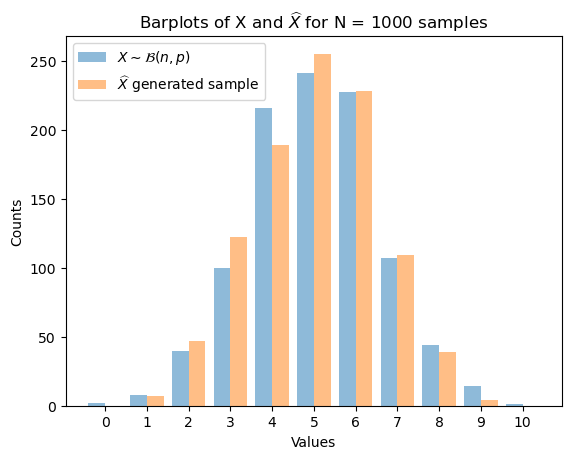

In [4]:

values, bins = np.histogram(X, bins=np.arange(n+2))
values2, _ = np.histogram(X_hat, bins=np.arange(n+2))

bar_width = 0.4

plt.bar(bins[:-1] - bar_width/2, values, width=bar_width, alpha=0.5, label='$X \sim \mathcal{B}(n,p)$ ')
plt.bar(bins[:-1] + bar_width/2, values2, width=bar_width, alpha=0.5, label='$\widehat{X}$ generated sample')

plt.title("Barplots of X and $\widehat{X}$ for" + f" N = {N_samples} samples")
plt.xlabel('Values')
plt.ylabel('Counts')
plt.xticks(bins[:-1], bins[:-1])
plt.legend()


plt.show()

## Exercice 2

### Question 2

In [5]:
def GMM(N_samples, probs, means, covs):
    nb = np.random.multinomial(N_samples, probs)
    X = []
    labels = []
    for i in range(len(probs)):
        u = np.random.multivariate_normal(means[i], covs[i], size=nb[i])
        X.append(u)
        labels.append(np.full(nb[i], i))
    return np.concatenate(X), np.concatenate(labels)

(1000, 2)


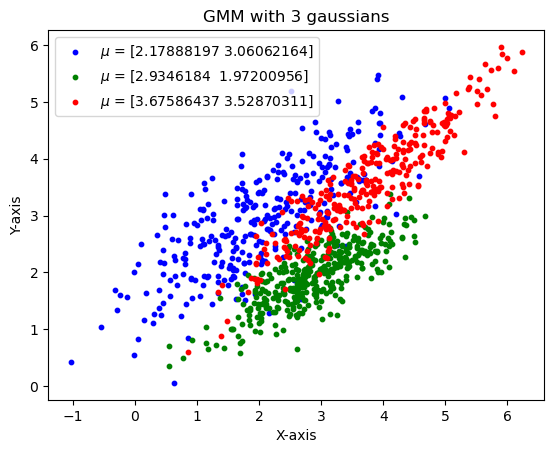

In [16]:
alphas = [0.3,0.4,0.3]
means = np.random.rand(3, 2)*5
covs = [np.random.rand(2, 2) for _ in range(3)]

for i in range(len(covs)):
    covs[i] = covs[i].T@covs[i]
N_samples = 1000
X,labels = GMM(N_samples,alphas,means,covs)
print(X.shape)
colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow']

# Tracer le scatter plot
for i in range(len(alphas)):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], s=10, c=colors[i], label=f'$\mu$ = {means[i]}')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title(f"GMM with {len(alphas)} gaussians")
plt.legend()
plt.show() 

### Question 3

In [17]:
def tau(X, means, covs, alphas):
    n, p = X.shape[0], len(alphas)
    Tau = np.zeros((n, p))
    

    for j in range(p):
        Tau[:, j] = alphas[j] * multivariate_normal(means[j], covs[j], allow_singular=True).pdf(X)
    

    Tau /= Tau.sum(axis=1, keepdims=True)

    return Tau


def Log_likelihood(X, means, covs, alphas):
    n, p = len(X), len(alphas)
    densities = np.array([alphas[j] * multivariate_normal(means[j], covs[j], allow_singular=True).pdf(X) for j in range(p)])
    log_likelihood = np.sum(np.log(np.sum(densities, axis=0)))

    return log_likelihood
def initialize_EM_GMM(X, p,type="kmeans"):
    n,d = X.shape[0],X.shape[1]
    
    #Lazy/Empirical initialization
    if type == "empirical":
        alphas = np.ones(p)/p
        means = X[np.random.randint(0,N_samples,p)]
        x_bar = np.mean(X,axis=0)
        sigma2 = np.mean((X-x_bar).T@(X-x_bar))
        covs = sigma2*(np.arange(1,p+1)).reshape(-1,1,1)*np.array(p*[np.eye(d)])

    #Kmeans initialization
    if type == "kmeans":
        kmeans = KMeans(n_clusters=p, random_state=0).fit(X)
        labels = kmeans.labels_

        means = kmeans.cluster_centers_

        covs = []
        for j in range(p):
            cluster_data = X[labels == j]
            covs.append(np.cov(cluster_data.T))
        covs = np.array(covs)

        alphas = np.array([np.mean(labels == j) for j in range(p)])
    
    return means, covs, alphas
    
def EM_GMM(X,p,n_iter=50,eps = 1e-2,verbose=0,init="kmeans"):
    means,covs,alphas = initialize_EM_GMM(X, p, init)
    if verbose == 1: print("Init:", means,covs,alphas)
    it = 0
    n,d= len(X),X.shape[1]
    L = Log_likelihood(X, means, covs, alphas)
    L_list = [L]
    if verbose == 1: print(f"Iteration {it}: Log-likelihood value = {L}")
    while (it < n_iter):
        it += 1

        #Step E
        Tau = tau(X, means, covs, alphas)

        #Step M
        nc= np.sum(Tau,axis=0)
        alphas = np.mean(Tau,axis=0) #size p
        means = np.dot(Tau.T, X)/nc.reshape(-1,1) #size p
        for j in range(p):
            covs[j] = sum([Tau[i,j]*np.outer(X[i]-means[j], X[i]-means[j]) for i in range(n)])/nc[j]
        

        L = Log_likelihood(X, means, covs, alphas)
        
        if np.abs(L-L_list[-1]) < eps:
            L_list.append(L)
            if verbose == 1: print(f"Stop: Variation < {eps}")
            break
        
        L_list.append(L)
        
        if verbose == 1: print(f"Iteration {it}: Log-likelihood value = {L}")
        
    
    return alphas,means,covs,L_list
    

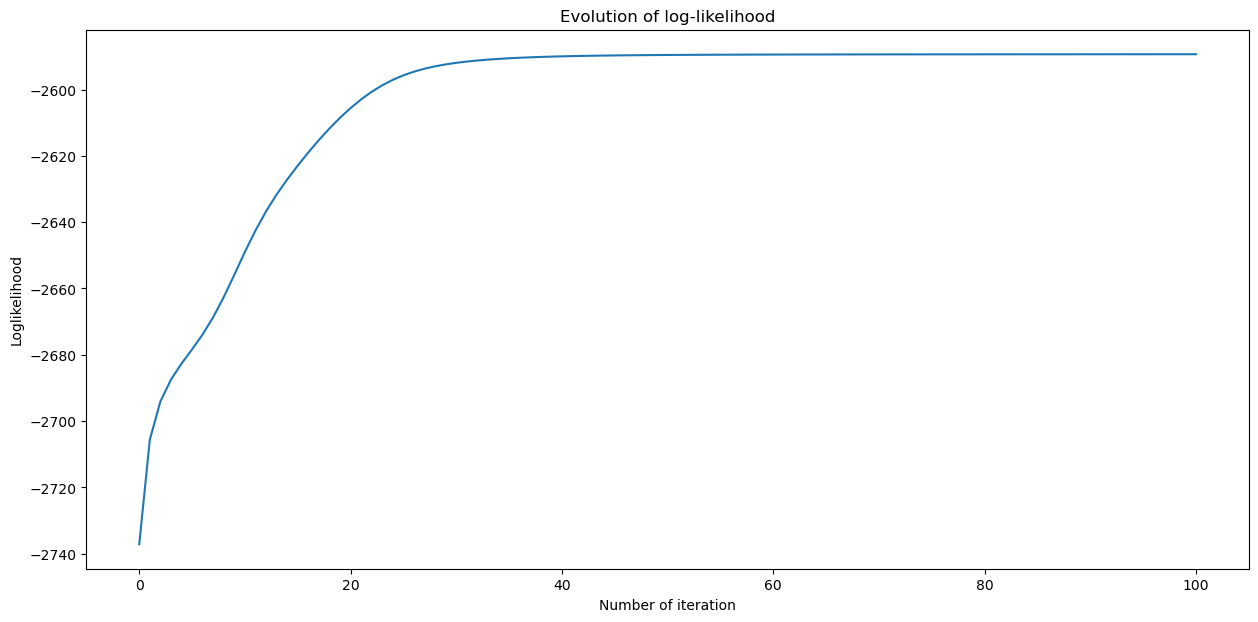

In [18]:
alphas_EM,means_EM,covs_EM,L_list = EM_GMM(X,p=3,n_iter=100,eps=1e-6,verbose=0,init="kmeans")

# Plot the results 
plt.figure(figsize=(15,7))
plt.plot(L_list)
plt.ylabel('Loglikelihood')
plt.xlabel('Number of iteration')
plt.title('Evolution of log-likelihood')

plt.show()

### Question 4

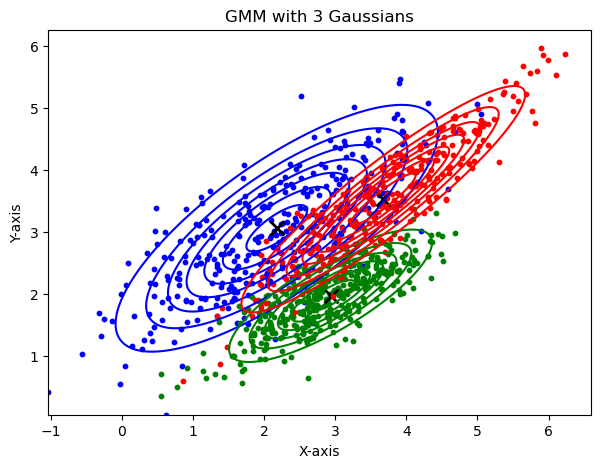

In [25]:
x, y = np.mgrid[np.min(X[:, 0]):np.max(X[:, 0]):.01, np.min(X[:, 1]):np.max(X[:, 1]):.01]
pos = np.dstack((x, y))

plt.figure(figsize=(7,5))
colors = ['blue', 'green', 'red']

for i in range(len(alphas)):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], s=10, c=colors[i])
    plt.scatter(means[i, 0], means[i, 1], c='black', marker='x', s=100, facecolor='black', linewidths=2)
for i in range(len(alphas)):
    rv = multivariate_normal(means[i], covs[i])
    plt.contour(x, y, rv.pdf(pos), colors=colors[i])

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title(f"GMM with {len(alphas)} Gaussians")
plt.show()

The plot above shows us that the estimated parameters are close to the true ones. Given a number of clusters, the algorithm manages to approximate relatively well the distribution of the data.

In [28]:
print("True weights: ", alphas)
print("Estimated weights: ", alphas_EM)

print("True means: ", means)
print("Estimated means: ", means_EM)

print("True covariances: ", covs)
print("Estimate covariances: ", covs_EM)

True weights:  [0.3, 0.4, 0.3]
Estimated weights:  [0.25949419 0.36816796 0.37233784]
True means:  [[2.17888197 3.06062164]
 [2.9346184  1.97200956]
 [3.67586437 3.52870311]]
Estimated means:  [[3.80325146 3.62987478]
 [2.17476931 2.92779117]
 [2.91351464 1.95465865]]
True covariances:  [array([[1.27147621, 0.8655961 ],
       [0.8655961 , 0.98070317]]), array([[0.53553   , 0.32221929],
       [0.32221929, 0.29999371]]), array([[0.96785337, 0.81830308],
       [0.81830308, 0.8115759 ]])]
Estimate covariances:  [[[1.02399641 0.89149985]
  [0.89149985 0.88855168]]

 [[1.21164107 0.74393306]
  [0.74393306 0.87309648]]

 [[0.51076703 0.30893018]
  [0.30893018 0.28791551]]]


### Question 5

In [30]:
df = pd.read_csv('WPP2019_Period_Indicators_Medium.csv')

In [31]:
df.head()

,LocID,Location,VarID,Variant,Time,MidPeriod,TFR,NRR,CBR,Births,...,CDR,Deaths,DeathsMale,DeathsFemale,CNMR,NetMigrations,GrowthRate,NatIncr,SRB,MAC
0,4,Afghanistan,2,Medium,1950-1955,1953,7.45,1.636,50.314,2015.476,...,36.862,1476.605,794.020,682.585,-0.499,-20.0,1.296,13.452,1.06,29.835
1,4,Afghanistan,2,Medium,1955-1960,1958,7.45,1.765,50.998,2201.589,...,33.718,1455.605,783.110,672.495,-0.463,-20.0,1.683,17.280,1.06,29.835
2,4,Afghanistan,2,Medium,1960-1965,1963,7.45,1.899,51.477,2439.130,...,30.808,1459.784,777.437,682.347,-0.422,-20.0,2.026,20.669,1.06,29.835
3,4,Afghanistan,2,Medium,1965-1970,1968,7.45,2.017,51.646,2728.221,...,28.223,1490.896,790.745,700.151,-0.379,-20.0,2.307,23.423,1.06,29.835
4,4,Afghanistan,2,Medium,1970-1975,1973,7.45,2.141,51.234,3056.451,...,25.495,1520.938,802.414,718.524,-0.335,-20.0,2.544,25.739,1.06,29.835


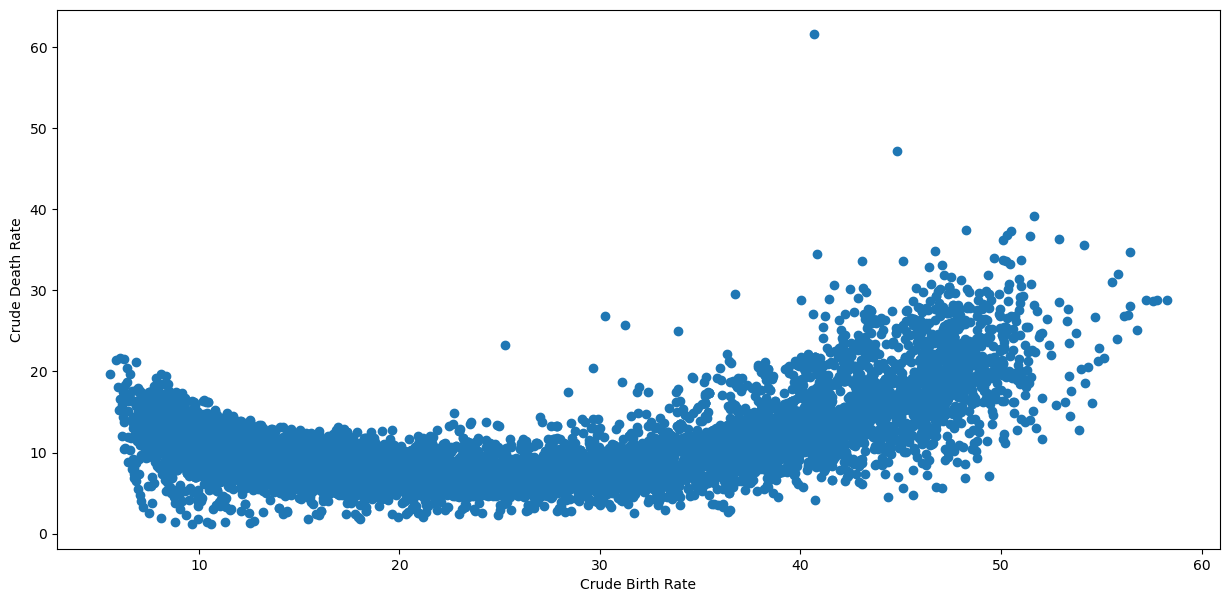

In [32]:
X_app = np.array(df[['CBR','CDR']].dropna())

plt.figure(figsize=(15,7))
plt.scatter(X_app[:,0],X_app[:,1])
plt.xlabel('Crude Birth Rate')
plt.ylabel('Crude Death Rate')
plt.show()

### Question 6

In [47]:
n_clusters = [2,3,4,5,6,7,8]

def BIC(L,p,n,d):
    dfp = p*d + p*d*(d+1)/2 + (p-1)    
    return -L + dfp*math.log(n)/2

def p_opt(X,n_clusters):
    n = len(X)
    Ls = []
    for p in n_clusters:
        a_EM,m_EM,c_EM,L = EM_GMM(X,p,n_iter=70,eps=1e-6,verbose=0,init="kmeans")
        BIC_value = BIC(L[-1],p,n,X.shape[1])
        print(f"BIC for p = {p}: {BIC_value}")
        Ls.append(BIC_value)
    return np.argmin(Ls)+2

p_opt = p_opt(X,n_clusters)
print("p optimal = ", p_opt)

BIC for p = 2: 2717.547292828504
BIC for p = 3: 2648.110002789881
BIC for p = 4: 2666.401245083941
BIC for p = 5: 2686.8359948181173
BIC for p = 6: 2705.3833873210206
BIC for p = 7: 2720.8036525097323
BIC for p = 8: 2741.1883842176458
p optimal =  3


### Exercice 3

In [50]:
def f(x):
    return 2*np.sin(2*np.pi*x/3)*(x>=0)

def p(x):
    return np.power(np.maximum(x, 0), 0.65) * np.exp(-np.square(np.maximum(x, 0))/2)

def q(x,mu=0.8,sigma2=1.5):
    return (2/np.sqrt(2*np.pi*sigma2))*np.exp(-np.square(mu-x)/(2*sigma2))

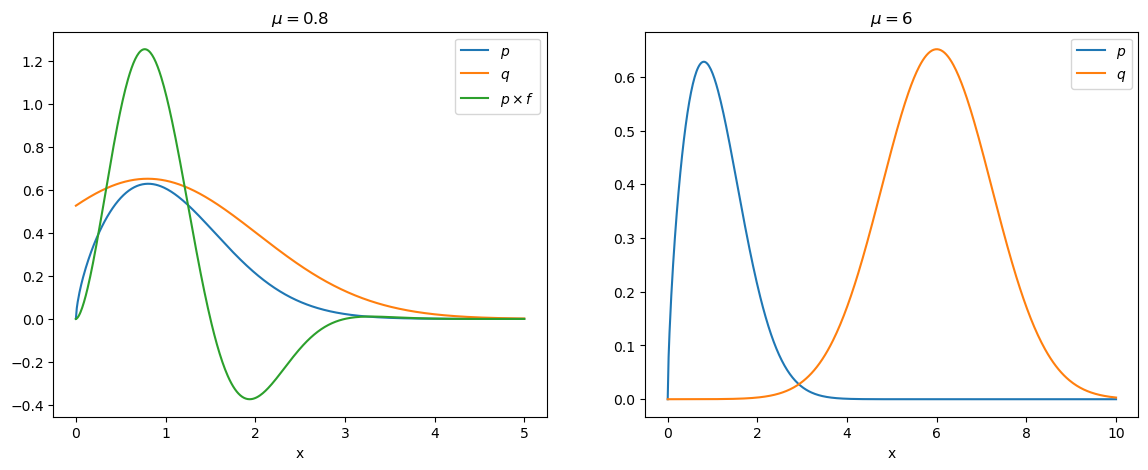

In [51]:
x1 = np.linspace(0, 5, 500)
x2 = np.linspace(0, 10, 500)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(x1, p(x1), label='$p$')
axs[0].plot(x1, q(x1, mu=0.8), label='$q$')
axs[0].plot(x1, p(x1) * f(x1), label='$p \\times f$')
axs[0].set_xlabel('x')
axs[0].set_title('$\mu = 0.8$')
axs[0].legend()

axs[1].plot(x2, p(x2), label='$p$')
axs[1].plot(x2, q(x2, mu=6), label='$q$')
#axs[1].plot(x2, p(x2) * f(x2), label='$p \\times f$')
axs[1].set_xlabel('x')
axs[1].set_title('$\mu = 6$')
axs[1].legend()

plt.show()

In [52]:
def Poor_importance_sampling(n,mu,sigma2):
    x = np.random.normal(size=n,loc=mu,scale=np.sqrt(sigma2))
    w = p(x)/q(x)
    w /= np.mean(w)
    return np.mean(f(x)*w),w

In [53]:
N = 10000
mu1 = 0.8
sigma2 = 1.5
estimate = Poor_importance_sampling(N,mu1,sigma2)[0]
print(estimate)

0.7816196453110155


In [54]:
Ns = [10,100,1000,10000]
estimates = []
for N in Ns:
    est = [Poor_importance_sampling(N,mu1,sigma2)[0] for _ in range(100)]
    print(f"---- N = {N} ----")
    print("Mean of estimate: ", np.mean(est))
    print("Variance of estimate: ", np.var(est))

---- N = 10 ----
Mean of estimate:  0.7556061771104814
Variance of estimate:  0.20370961351552672
---- N = 100 ----
Mean of estimate:  0.7637006886565365
Variance of estimate:  0.0196496119965857
---- N = 1000 ----
Mean of estimate:  0.7710435351366669
Variance of estimate:  0.0015432863097143903
---- N = 10000 ----
Mean of estimate:  0.7681844834917472
Variance of estimate:  0.0002327895623547959


The variance of the estimation for larger values of $N$ are smaller. The law of large numbers ensures that the average of the sample weights converges to the expected value, reducing variability. More samples provide a better approximation of the target distribution.

In [55]:
mu2 = 6
Ns = [10,100,1000,10000]
estimates = []
for N in Ns:
    est = [Poor_importance_sampling(N,mu2,sigma2)[0] for _ in range(100)]
    print(f"---- N = {N} ----")
    print("Mean of estimate: ", np.mean(est))
    print("Variance of estimate: ", np.var(est))
    


---- N = 10 ----
Mean of estimate:  -0.14241093955952283
Variance of estimate:  1.132235034926749
---- N = 100 ----
Mean of estimate:  0.3433174096654852
Variance of estimate:  0.18575232941898792
---- N = 1000 ----
Mean of estimate:  0.25939663814897007
Variance of estimate:  0.03572533070008429
---- N = 10000 ----
Mean of estimate:  0.24784441268300234
Variance of estimate:  0.0038282765188292034


When the sampling distribution $q$ does not match the target distribution $p$ well, there may be regions where one is relatively high while the other is very low , leading to very high importance weights. As we can see in the plot for $\mu = 6$, for a given $x$ either $q$ is heigh and $p$ is low, or $q$ is low and $p$ is heigh. That's why we see a bigger variance of the weights.

In [56]:
print("Variance of the weights for mu = 0.8: ", np.var(Poor_importance_sampling(N,mu1,sigma2)[1]))
print("Variance of the weights for mu = 6", np.var(Poor_importance_sampling(N,mu2,sigma2)[1]))

Variance of the weights for mu = 0.8:  0.553955832685222
Variance of the weights for mu = 6 13.25016211588708
